# シミュレーテッドアニーリングとベイズ線形回帰によるベイズ最適化

## 文献情報

- タイトル: Bayesian Optimization of Combinatorial Structures
- 著者: R. Baptista and M. Poloczek
- 書誌情報: https://proceedings.mlr.press/v80/baptista18a.html

## 概要

本記事では、目的関数 $f: \mathcal X \to \mathbb R$ を最小化する入力 $x^\ast \in \mathcal X$ を見つける問題のうち、目的関数の内部構造が不明で、目的関数の値の計算に時間が生じるような問題を解くことを想定します。

$$
\begin{aligned}
    & \mathop{\rm minimize}\limits_{x \in \mathcal X} && f(x) \\
    & \mathop{\rm where}
    &&  \text{$f$ の内部構造は不明,} \\
    &&& \text{$f(x)$ の評価に時間がかかる}
\end{aligned}
$$

目的関数の計算に時間がかかるという性質上、焼きなまし法 (SA, simulated annealing) のように、目的関数の評価を何度も実行するメタヒューリスティクス手法の適用は実用的ではありません。そこで使用されるのがモデルベース最適化 (model-based optimization) です。モデルベース最適化では目的関数の入出力関係を近似する “代理モデル” (surrogate model) と呼ばれる回帰モデル $\hat f$ を導入し、以下のようなステップを実行します。

1. 代理モデル $\hat f$ を既知のデータセット $\mathcal D^{(t-1)}$ を用いて更新する
2. 獲得関数 $\alpha: \mathcal X \to \mathbb R$ を代理モデル $\hat f$ を用いて生成する
3. 評価する点 $x^{(t)}$ を獲得関数を最小化することで得る: $x^{(t)} \gets \mathop{\rm arg~min}_{x \in \mathcal X} \alpha(x)$
4. 目的関数の値 $y^{(t)} = f(x^{(t)})$ を得る
5. データセットに新しいデータを追加する: $\mathcal D^{(t)} \gets \mathcal D \cup \{(x^{(t)}, y^{(t)})\}$
6. ステップ $t$ をインクリメント
7. 1.-6.を終了条件に達するまで繰り返す

本記事では、組合せ最適化問題に対するモデルベース最適化の一手法である、**焼きなまし法を用いた Bayesian optimization of combinatorial structures**、通称 `BOCS-SA` を実装していきます。

なお、今回の実装については論文著者等による実装コード https://github.com/baptistar/BOCS/blob/master/BOCSpy/LinReg.py も一部参考にしていますが、具体的な当該コードを本記事に流用することなどは一切行っていないため、本記事のコードは論文著者等のコードに由来するGPLライセンスには該当しません。

## 環境設定

### ライブラリのインストール

In [ ]:
!pip install openjij
!pip install matplotlib
!pip install torch
!pip install tqdm

### ライブラリのインポート

In [2]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import openjij as oj
from typing import Optional

## 代理モデル

BOCSでは、代理モデルとして入力変数間の2次の項までを考慮する多項式回帰モデルを使用します。

$$
\begin{aligned}
    \hat f(x; w) = w_0 + \sum_{i=1}^d w_i x_i + \sum_{i \lt j} w_{ij} x_i x_j.
    &&
    x \in \{0, 1\}^{d}
\end{aligned}
$$

入力 $x$ は各成分が $0$ または $1$ の $d$ 次元ベクトルとします。上記のモデルは各パラメータ $b, w$ について1次式であるため、線形回帰モデル

$$
    \hat f(\bm x; \bm \beta) = \bm z^\top \bm \beta
$$

に書き直すことができます。したがってベイズ線形回帰の方法でパラメータ $\theta$ のベイズ推定を行うことができます。ただし

$$
\begin{aligned}
\bm z &= [1, x_1, \dots, x_d, x_1 x_2, \dots, x_{d-1} x_d]^\top \in \{ 0, 1 \}^{p}, \\
\bm \beta &= [w_0, w_1, \dots, w_d, w_{12}, \dots, w_{(d-1)d}]^\top \in \mathbb R^{p}, \\
p &= 1 + d + \frac{d(d-1)}{2}.
\end{aligned}
$$

理論上は3次以上の項まで考慮することで表現力を向上させることも可能ですが、実用的ではありません。パラメータの個数 $p$ が代理モデルの次数に対し指数オーダーで増加するので、モデルの学習に必要なサンプル点 $(x,y)$ の個数 $N_{\rm req} = |\mathcal D|$ も同様に指数関数的に増加し、さらに学習コストも爆発的に増大してしまうからです。言い換えれば、**表現力とコストはトレードオフの関係にある**と言えます。元論文では2次までの項を考慮するのが最もバランスがよいと主張しているため、ここでもそれに従います。

パラメータの個数 $p$ は、変数 $x$ の次元 $d$ を用いて

$$
p = 1 + d + \binom{d}{2} = 1 + d + \frac{d (d-1)}{2}
$$

により与えられます。

以上、$p, z$ を作成する関数を準備します。

In [3]:
def d_to_p(d: int) -> int:
    p = 1 + d + d * (d - 1) // 2
    return p


def x_to_z(x: np.ndarray) -> np.ndarray:
    d = len(x)
    p = d_to_p(d)

    z = np.zeros(p, dtype=int)

    # bias
    z[0] = 1

    # linear
    z[1 : d + 1] = x

    # quadratic
    i, j = np.triu_indices(d, k=1)
    z[d + 1 :] = x[i] * x[j]
    return z

In [4]:
# TEST

x = np.random.choice([0, 1], 10)
z = x_to_z(x)
print("z:\n", z)

print("-" * 10)

x_data = np.random.choice([0, 1], (5, 10))
z_data = np.apply_along_axis(x_to_z, 1, x_data)
print("z_data:\n", z_data)

z:
 [1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0]
----------
z_data:
 [[1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0]
 [1 1 1 1 0 0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0]
 [1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0]]


以上を代理モデルとしてまとめておきます。

In [5]:
class BOCSSurrogateModel:
    def __init__(self, num_vars, linear_regressor, remove_duplicate: bool = True):
        num_features = d_to_p(num_vars)
        coef = np.zeros(num_features, dtype=np.float64)
        self.params = {"coef": coef}
        self.linear_regressor = linear_regressor

    def update(self, x_data, y_data):
        z_data = np.apply_along_axis(x_to_z, 1, x_data)
        self.linear_regressor.fit(z_data, y_data)
        self.params["coef"] = self.linear_regressor.coef_

In [6]:
# TEST

num_vars = 16
linear_regressor = None

bocs_surrogate_model = BOCSSurrogateModel(num_vars, linear_regressor)
print(bocs_surrogate_model.params)

{'coef': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])}


## Thompson抽出

BOCSは **Thompson抽出** (Thompson sampling) と呼ばれる手法の1つです。Thompson抽出は代理モデルがパラメータ $\theta$ に特徴づけられる関数 $\hat f(x; \theta)$ の場合によく使用される手法で、

1. パラメータの事後分布 $p(\tilde \theta \mid \mathcal D)$ を計算
2. 事後分布に従うサンプル $\tilde{\theta} \sim p(\tilde \theta \mid \mathcal D)$ を1つ引く
3. サンプルを用いた代理モデル $\hat f(x; \tilde \theta)$ を獲得関数 $\alpha(x)$ とする

というステップにより得られる関数 $\alpha(x)$ を獲得関数とします。

$$
\begin{aligned}
    \alpha(x) = \hat f(x; \tilde \theta) \quad
    \text{where} \quad
    \tilde \theta \sim p(\theta \mid \mathcal D)
\end{aligned}
$$

このアルゴリズムは、以下の確率規則に従って新しいデータを評価する点を選択していることになります。

$$
\begin{aligned}
    P(x \mid \mathcal D) = \int d\theta~ \delta\! \left( x - \operatorname*{arg~min}_x \hat f(x; \theta) \right) 
    (\theta \mid \mathcal D)
\end{aligned}
$$

Thompson抽出を実装するには、**事後分布からのサンプリング** を行うアルゴリズムが必要です。次節ではBOCSで使用されるベイズ線形回帰による事後分布の推定方法について説明します。

### ベイズ線形回帰

線形回帰のベイズ的な取り扱い方を説明します。線形回帰は入力 $\bm x^{(t)} \in \mathbb R^{p}$ と出力 $y^{(t)} \in \mathbb R$ の関係を次のようにモデル化します。

$$
\begin{aligned}
    y^{(t)}
    &= \beta_1 x^{(t)}_1 + \beta_2 x^{(t)}_2 + \dots + \beta_p x^{(t)}_p + \varepsilon^{(t)} \\
    &= \bm x^{(t) \top} \bm \beta + \varepsilon^{(t)}.
\end{aligned}
$$

$\bm \beta \in \mathbb R^{p}$ は回帰係数、$\varepsilon^{(t)}$ はノイズです。ノイズには通常、次のような正規分布を仮定します。

$$
\begin{aligned}
    \varepsilon^{(t)} \sim \mathcal N(0, \sigma^2).
\end{aligned}
$$

これは出力 $y^{(t)}$ が平均 $\bm x^{(t)\top} \bm \beta$、分散 $\sigma^2$ の正規分布に従うと仮定していることと等価です。

$$
\begin{aligned}
    y^{(t)} \mid \bm x^{(t)}, \bm \beta, \sigma \sim \mathcal N(\bm x^{(t)\top} \bm \beta, \sigma^2).
\end{aligned}
$$

この $y^{(t)}$ が従う確率分布の確率密度関数は次式で与えられます。

$$
\begin{aligned}
    p(y^{(t)} \mid \bm x^{(t)}, \bm \beta, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{1}{2\sigma^2} (y^{(t)} - \bm x^{(t) \top} \bm \beta)^2 \right).
\end{aligned}
$$

行いたいことは、係数 $\bm \beta$ と標準偏差 $\sigma$ をデータ $\mathcal D = \{(\bm x^{(t)}, y^{(t)})\}_{t=1, \dots, N}$ をもとに推定することです。ベイズ推定の枠組みでこれを行う1つの方法は「係数 $\bm \beta$ と標準偏差 $\sigma$ の確率分布 $p(\bm \beta, \sigma \mid \bm X, \bm y)$ を求める」ことです。そのために次のベイズの定理を用います。

$$
\begin{aligned}
    p(\bm \beta, \sigma \mid \bm X, \bm y)
    &= \frac{p(\bm y \mid \bm X, \bm \beta, \sigma) p(\bm \beta, \sigma)}{p(\bm y \mid \bm X)} \\
    &\propto p(\bm y \mid \bm X, \bm \beta, \sigma) p(\bm \beta, \sigma).
\end{aligned}
$$

ただし $\bm y=[y^{(1)}, \dots, y^{(N)}]^\top, \bm X=[\bm x^{(1) \top}, \dots, \bm x^{(N) \top}]^\top$ です。この式によれば、事前分布 $p(\bm \beta, \sigma)$ を設定し、これにモデルの確率分布 $p(y^{(t)} \mid \bm x^{(t)}, \bm \beta, \sigma)$ を掛け、更に定数倍して規格化すれば、パラメータの事後分布 $p(\bm \beta, \sigma \mid \bm X, \bm y)$ が求まります。

### 馬蹄分布の定式化

BOCSでは、スパース性を仮定する馬蹄分布 (horseshoe prior) と呼ばれる事前分布を用います。馬蹄分布の定式化には [Makalic & Schmidt (2016)] による次の定式化を用います。

$$
\begin{aligned}
    y \mid \bm x, \bm \beta, \sigma
        &\sim \mathcal N(\bm x^\top \bm \beta, \sigma^2), \\
    \beta_i \mid \sigma, \lambda_i, \tau
        &\sim \mathcal N(0, \sigma^2 \tau^2 \lambda_i^2),
        & i=1,\dots,p, \\
    \sigma^2 \mid a, b
        &\sim \mathrm{InvGamma}(a, b), \\
    \lambda_i
        &\sim \mathrm{HalfCauchy} (0, 1),
        & i=1,\dots,p, \\
    \tau
        &\sim \mathrm{HalfCauchy} (0, 1).
\end{aligned}
$$

ただし $y \in \mathbb R, \bm x \in \mathbb R^p, \bm \beta \in \mathbb R^p$ です。$\mathrm{HalfCauchy}(0, 1)$ は位置パラメータ $0$、尺度パラメータ $1$ の **半コーシー分布** と呼ばれる分布で、以下の確率密度関数で表されます。

$$
    p(x) = \frac{2}{\pi} \frac{1}{1 + x^2}.
$$

### Gibbsサンプリングの定式化

ベイズの定理に従って事後分布 $p(\bm \beta \mid \mathcal D)$ を計算します。しかし半コーシー分布 $\mathrm{HalfCauchy} (0, 1)$ と正規分布 $\mathcal N(0, \sigma^2 \tau^2 \lambda_i^2)$ は相性が悪く、そのままでは解析的に事後分布を導出することはできません。そこで、[Makalic & Schmidt (2016)] の取扱いに従い、文献 [Wand+ (2011)] に記載されている定理より導かれる以下の補題を利用して、半コーシー分布を逆ガンマ分布に書き換えます。

---

**補題 [Wand+ (2011)]** $x$ が半コーシー分布 $\mathrm{HalfCauchy} (x \mid 0, a)$ に従うならば、$x^2$ は2段階の階層的な逆ガンマ分布の混合に従う。

$$
\begin{aligned}
    x^2 \mid a' &\sim \mathrm{InvGamma} \left( x^2 \,\middle|\, \frac{1}{2}, \frac{1}{a'}  \right), \\
    a'  \mid a  &\sim \mathrm{InvGamma} \left( a'  \,\middle|\, \frac{1}{2}, \frac{1}{a^2} \right).
\end{aligned}
$$

---

これを用いれば、$\lambda_i \sim \mathrm{HalfCauchy}(0,1)$ という部分は補助変数 $\nu_i$ を導入することで

$$
\begin{aligned}
    \lambda_i^2 \mid \nu_i &\sim \mathrm{InvGamma} \left( \lambda_i^2 \,\middle|\, \frac{1}{2}, \frac{1}{\nu_i} \right), \\
    \nu_i               &\sim \mathrm{InvGamma} \left( \nu_i       \,\middle|\, \frac{1}{2}, 1               \right)
\end{aligned}
$$

という階層構造に書き直すことができます。$\tau \sim \mathrm{HalfCauchy}(0,1)$ についても同様の書き換えを施すことができ、最終的にすべての条件付き分布が正規分布と逆ガンマ分布の形で書かれます。

$$
\begin{aligned}
    \beta_i \mid \sigma, \tau, \lambda_i
    &\sim \mathcal{N}(\beta_i \mid 0, \sigma^2 \tau^2 \lambda_i^2),
    & i &= 1, \dots, p,
    \\
    \sigma^2 \mid a, b
    &\sim \mathrm{InvGamma} \left( \sigma^2 \,\middle|\, a, b \right),
    \\
    \lambda_i^2 \mid \nu_i
    &\sim \mathrm{InvGamma} \left( \lambda_i^2 \,\middle|\, \frac{1}{2}, \frac{1}{\nu_i} \right),
    & i &= 1, \dots, p,
    \\
    \nu_i
    &\sim \mathrm{InvGamma} \left( \nu_i \,\middle|\, \frac{1}{2}, 1 \right),
    & i &= 1, \dots, p,
    \\
    \tau^2 \mid \xi
    &\sim \mathrm{InvGamma} \left( \tau^2 \,\middle|\, \frac{1}{2}, \frac{1}{\xi} \right),
    \\
    \xi
    &\sim \mathrm{InvGamma} \left( \xi \,\middle|\, \frac{1}{2}, 1 \right).
\end{aligned}
$$

この階層構造から、ベイズの定理で各パラメータの条件付き事後分布が得られます。

$$
\begin{aligned}
    \bm \beta \mid \bm X, \bm y, \bm \beta, \sigma, \bm \lambda, \tau
    &\sim \mathcal{N}(\bm A^{-1} \bm X^\top \bm y, \sigma^2 \bm A^{-1}), 
\\
    \sigma^2 \mid \bm X, \bm y, \bm \lambda, \tau, a, b
    &\sim \mathrm{InvGamma} \left( a + \frac{N}{2}, b + \frac{\bm y^\top (\bm I_N + \bm X \tau^2 \operatorname{diag}\{\lambda_i^2\} \bm X^\top )^{-1} \bm y}{2} \right),
\\
    \lambda_i^2 \mid \bm \beta, \sigma, \tau, \bm \nu
    &\sim \mathrm{InvGamma} \left( 1, \frac{1}{\nu_i} + \frac{1}{2 \sigma^2} \frac{\beta_i^2}{\tau^2} \right),
    & i &= 1, \dots, p,
\\
    \nu_i \mid \bm \lambda
    &\sim \mathrm{InvGamma} \left( 1, 1 + \frac{1}{\lambda_i^2} \right),
    & i &= 1, \dots, p,
\\
    \tau^2 \mid \bm \beta, \sigma, \bm \lambda, \xi
    &\sim \mathrm{InvGamma} \left( \frac{p + 1}{2}, \frac{1}{\xi} + \frac{1}{2 \sigma^2} \sum_{i=1}^p \frac{\beta_i^2}{\lambda_i^2} \right),
\\
    \xi \mid \tau
    &\sim \mathrm{InvGamma} \left( 1, 1 + \frac{1}{\tau^2} \right),
\end{aligned}
$$

ただし

$$
\begin{aligned}
  \bm X &=
  \begin{bmatrix}
    \bm x^{(1) \top} \\ \bm x^{(2) \top} \\ \vdots \\ \bm x^{(N) \top}
  \end{bmatrix} \in \mathbb R^{N \times p},
  \\
  y &=
  \begin{bmatrix}
    y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(N)}
  \end{bmatrix} \in \mathbb R^{N},
  \\
  \bm A &= \bm X^\top \bm X + \frac{1}{\tau^2} \operatorname{diag}\left\{ \frac{1}{\lambda_i^2} \right\}
\end{aligned}
$$

以上導出された各パラメータの条件付き事後分布から1つ1つパラメータをサンプリングしていくGibbsサンプリングと呼ばれる方法により、事後分布に従うサンプルを生成することが可能です。

In [7]:
def sample_from_inv_gamma(shape, scale):
    return 1.0 / np.random.gamma(shape, 1.0 / scale)


def sample_coef(sigma2, lamb2, tau2, X, y):
    Phi = X / np.sqrt(sigma2)
    alpha = y / np.sqrt(sigma2)
    delta = tau2 * lamb2 * sigma2

    N, p = Phi.shape
    u = np.random.normal(0.0, np.sqrt(delta), p)
    d = np.random.normal(0.0, 1.0, N)
    v = Phi @ u + d
    try:
        w = np.linalg.solve((delta * Phi) @ Phi.T + np.eye(N), alpha - v)
    except np.linalg.LinAlgError:
        w = np.linalg.lstsq((delta * Phi) @ Phi.T + np.eye(N), alpha - v, rcond=None)[0]
    coef_new = u + (delta * Phi).T @ w

    return coef_new


def sample_sigma2(lamb2, tau2, X, y, a, b):
    N, p = X.shape
    shape = a + N / 2

    XDX_In = (tau2 * lamb2 * X) @ X.T + np.eye(N)
    scale = b + y @ np.linalg.solve(XDX_In, y) / 2

    sigma2_new = sample_from_inv_gamma(shape, scale)
    return sigma2_new


def sample_lamb2(coef, sigma2, lamb2, tau2):
    shape = 1.0
    scale = 1.0 + 1.0 / lamb2
    nu = sample_from_inv_gamma(shape, scale)

    shape = 1.0
    scale = 1.0 / nu + coef**2 / tau2 / sigma2 / 2
    lamb2_new = sample_from_inv_gamma(shape, scale)
    return lamb2_new


def sample_tau2(coef, sigma2, lamb2, tau2):
    shape = 1.0
    scale = 1.0 + 1.0 / tau2
    xi = sample_from_inv_gamma(shape, scale)

    p = len(coef)
    shape = (p + 1) / 2
    scale = 1.0 / xi + np.sum(coef**2 / lamb2) / sigma2 / 2
    tau2_new = sample_from_inv_gamma(shape, scale)
    return tau2_new

こうして作成された各サンプリングの関数をまとめてループさせます。

In [8]:
def markov_transition(
    X: np.ndarray,
    y: np.ndarray,
    coef: np.ndarray,
    sigma2: float,
    lamb2: float,
    tau2: float,
    a_sigma2: float,
    b_sigma2: float,
):
    tau2_new = sample_tau2(coef, sigma2, lamb2, tau2)
    sigma2_new = sample_sigma2(lamb2, tau2_new, X, y, a_sigma2, b_sigma2)
    coef_new = sample_coef(sigma2_new, lamb2, tau2_new, X, y)
    lamb2 = sample_lamb2(coef_new, sigma2_new, lamb2, tau2_new)

    return coef_new, sigma2_new, lamb2, tau2_new


def horseshoe_gibbs_sampling(
    X,
    y,
    coef,
    sigma2,
    lamb2,
    tau2,
    a_sigma2,
    b_sigma2,
    max_iter,
    show_progress_bar: bool,
):
    coefs: np.ndarray = np.zeros((max_iter, len(coef)))
    sigma2s: np.ndarray = np.zeros(max_iter)
    lamb2s: np.ndarray = np.zeros((max_iter, len(coef)))
    tau2s: np.ndarray = np.zeros(max_iter)

    if show_progress_bar:
        iterator = tqdm(range(max_iter))
    else:
        iterator = range(max_iter)
    for mcs in iterator:
        coef, sigma2, lamb2, tau2 = markov_transition(
            X, y, coef, sigma2, lamb2, tau2, a_sigma2, b_sigma2
        )

        coefs[mcs] = coef
        sigma2s[mcs] = sigma2
        lamb2s[mcs] = lamb2
        tau2s[mcs] = tau2

    return coefs, sigma2s, lamb2s, tau2s

In [9]:
class HorseshoeGibbs:
    def __init__(self, max_iter: int = 50, warm_start: bool = True, show_progress_bar: bool = False):
        self.max_iter = max_iter
        self.warm_start = warm_start

        self.coef_ = None
        self.sigma2_ = None
        self.lamb2_ = None
        self.tau2_ = None
        self.hyperparams = {
            "a_sigma2": 0.5,
            "b_sigma2": 0.5,
        }
        self.config = {
            "show_progress_bar": show_progress_bar,
        }
        self.is_initilized = False

    def initialize_params(self, num_features):
        self.coef_ = np.zeros(num_features, dtype=np.float64)
        self.sigma2_ = 1.0
        self.lamb2_ = np.random.uniform(0.0, 1.0, num_features).astype(np.float64)
        self.tau2_ = np.random.uniform(0.0, 1.0)
        self.is_initilized = True

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        return_samples = False,
    ):
        if not self.is_initilized or not self.warm_start:
            self.initialize_params(X.shape[1])

        coef = self.coef_
        sigma2 = self.sigma2_
        lamb2 = self.lamb2_
        tau2 = self.tau2_

        coefs, sigma2s, lamb2s, tau2s = horseshoe_gibbs_sampling(
            X,
            y,
            coef,
            sigma2,
            lamb2,
            tau2,
            self.hyperparams["a_sigma2"],
            self.hyperparams["b_sigma2"],
            self.max_iter,
            self.config["show_progress_bar"],
        )

        self.coef_ = coefs[-1]
        self.sigma2_ = sigma2s[-1]
        self.lamb2_ = lamb2s[-1]
        self.tau2_ = tau2s[-1]

        if return_samples:
            return coefs, sigma2s, lamb2s, tau2s

  0%|          | 0/400 [00:00<?, ?it/s]

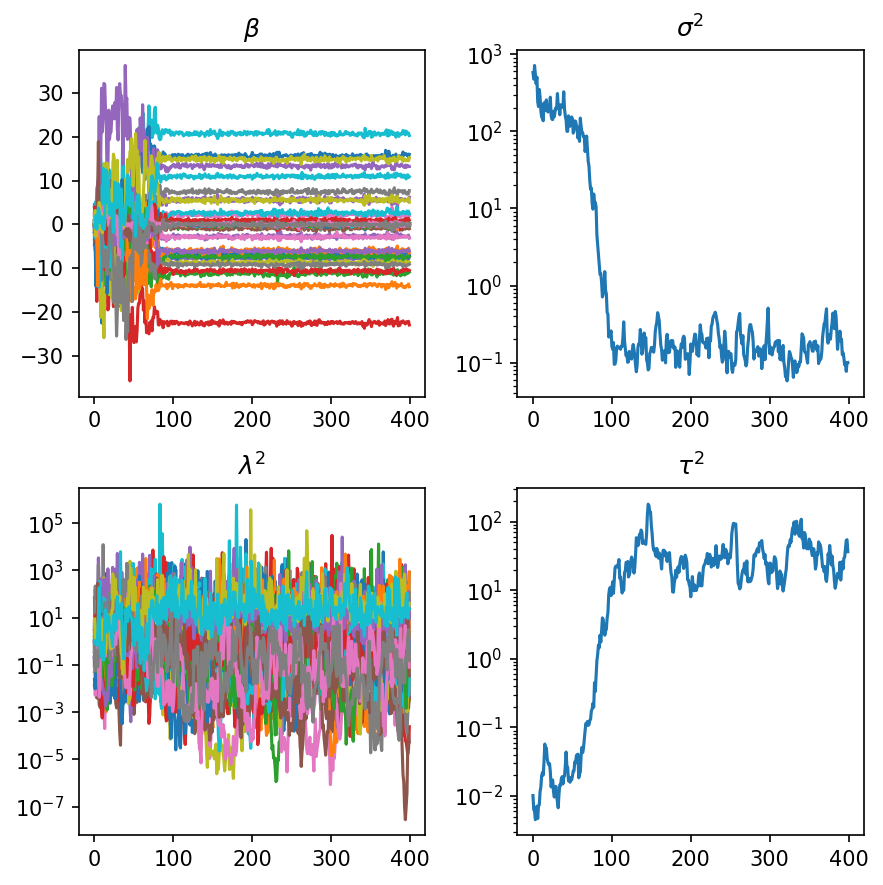

In [10]:
# TEST
num_features = 50
num_samples = 50

coef_raw = np.random.normal(0, 10, size=num_features)
coef_mask = np.random.choice([0, 1], size=num_features)
coef_true = coef_raw * coef_mask

x_data = np.random.choice([0, 1], size=(num_samples, num_features))
y_data = x_data @ coef_true + np.random.normal(0, 0.1, size=num_samples)

horseshoe = HorseshoeGibbs(max_iter=400, show_progress_bar=True)
coefs, sigma2s, lamb2s, tau2s = horseshoe.fit(x_data, y_data, return_samples=True)

fig, axes = plt.subplots(2, 2, figsize=(6,6), dpi=150)
axes[0][0].plot(coefs)
axes[0][0].set_title(r"$\beta$")
axes[0][1].plot(sigma2s)
axes[0][1].set_yscale("log")
axes[0][1].set_title(r"$\sigma^2$")
axes[1][0].plot(lamb2s)
axes[1][0].set_yscale("log")
axes[1][0].set_title(r"$\lambda^2$")
axes[1][1].plot(tau2s)
axes[1][1].set_yscale("log")
axes[1][1].set_title(r"$\tau^2$")
fig.tight_layout()

### 多変量正規分布からの効率的なサンプリング

上述のGibbsサンプリングにおいてボトルネックとなるのが $\bm \beta \mid \mathcal D, \bm \beta \setminus \{\theta\}$ のサンプルで、この部分は (1) 逆行列 $A^{-1}$ の計算、(2)多変量正規分布 $\mathcal{N}(A^{-1} X^\top y, \sigma^2 A^{-1})$ からのサンプリング、のいずれも $\mathcal O(p^3) = \mathcal O(d^6)$ もの時間計算量を要求します。この部分を高速化するために、先程のコードでは [Bhattacharya+ (2016)] による以下のアルゴリズムを使用しています。

---

**アルゴリズム [Bhattacharya+ (2016)]**: 以下の多変量正規分布を考える。

$$
\begin{aligned}
    \bm \beta \sim \mathcal N(m, V)
\end{aligned}
$$

ただし

$$
\begin{aligned}
    m &= V \Phi^\top \alpha && \in \mathbb{R}^{p}, \\
    V &= \left( \Phi^\top \Phi + \Delta^{-1} \right)^{-1} && \in \mathbb{R}^{p \times p}
\end{aligned}
$$

であり、$\Phi \in \mathbb R^{N \times p}$、$\alpha \in \mathbb R^N$、$\Delta \in \mathbb R^{p \times p}$、さらに $\Delta$ は正定値行列である。

この分布に従うサンプル $\bm \beta \in \mathbb R^p$ は、以下の方法により生成可能である。

1. $u \in \mathbb R^p$ を多変量正規分布 $\mathcal N(0, \Delta)$ からサンプルする
2. $v \in \mathbb R^N$ を多変量正規分布 $\mathcal N(\Phi u, I)$ からサンプルする
3. 線形方程式 $(\Phi \Delta \Phi^\top + I) w = (\alpha - v)$ を $w$ について解く
4. $\bm \beta = u + \Delta \Phi^\top w$ を計算する

---

アルゴリズムの正当性はSherman–Morrison–Woodburyの公式により示されます。

このアルゴリズムに $\bm \beta \mid \cdot \sim \mathcal{N}(\bm A^{-1} \bm X^\top \bm y, \sigma^2 \bm A^{-1})$ を当てはめると、

$$
\begin{aligned}
    \Phi = \frac{X}{\sigma}, \quad
    \alpha = \frac{y}{\sigma}, \quad
    \Delta = \mathop{\rm diag} \left\{ \tau_i^2 \lambda^2 \sigma^2 \right\}
\end{aligned}
$$

となります。

以上のアルゴリズムにおいて、最大のボトルネックとなるのは線形方程式を解く部分です。詳細は省略しますが、行列 $\Delta$ がスパースな場合には $\mathcal O(p N^2)$ が、$\Delta$ がスパースでない場合には $\mathcal O(p^2 N)$ が支配的になります。今回の設定ではいずれにせよ $\mathcal O(p^3)$ に比べれば $p$ への依存性が小さくなることが確認できます。

`sample_theta()` 関数では、以上のロジックを用いてサンプリングを高速化するよう工夫しています。

### 獲得関数の最適化

得られたサンプル $\tilde{\bm \beta} \sim p(\bm \beta | \mathcal D)$ を用いた2次多項式モデル $\alpha(\bm x) = \hat f(\bm x; \tilde{\bm \beta})$ を最小化する入力 $x^{(t+1)} = \mathop{\rm arg~min}_x \alpha(x)$ が、次に入力するサンプルとなります。ここからは、この入力を探索するロジックを作成します。

2次多項式モデルが、次式で表されるようなQUBO (quadratic unconstrained binary optimization, 二次無制約二値最適化問題) 形式に書き直せる点に注目します。

$$
\begin{aligned}
    \mathop{\rm minimize}\limits_{\bm x \in \{0, 1\}^d} \quad \bm x^\top \bm Q \bm x
\end{aligned}
$$

このことを用いて回帰係数をQUBO行列に変換し、焼きなまし法 (SA) で低エネルギー状態をサンプルすることで次の入力を決定します。

SAによるサンプリングは `openjij` による実装を使用します。

In [11]:
def calc_num_vars_from_num_features(num_features: int) -> int:
    return int((-1 + np.sqrt(8 * num_features - 7)) // 2)


def calc_Q_from_coef(coef: np.ndarray) -> np.ndarray:
    num_features = len(coef)
    num_vars = calc_num_vars_from_num_features(num_features)
    Q = np.zeros((num_vars, num_vars))
    i, j = np.diag_indices(num_vars)
    Q[i, j] = coef[1 : num_vars + 1]
    i, j = np.triu_indices(num_vars, k=1)
    Q[i, j] = coef[num_vars + 1 :]
    return Q


class BOCSAcquisitionFunction:
    def __init__(self, optimizer: oj.SASampler.sample_qubo):
        self.optimizer = optimizer

    def build(self, surrogate_model):
        coef = surrogate_model.params["coef"]
        Q = calc_Q_from_coef(coef)
        self.Q = Q

    def optimize(self) -> np.ndarray:
        response = self.optimizer(self.Q)
        optimal_x = np.array(list(response.first.sample.values()), dtype=int)
        return optimal_x

In [12]:
# TEST 真のQ_trueと推定されたQの類似度を計算

num_vars = 10
num_samples = 250

Q_true = np.triu(np.random.normal(0, 10, size=(num_vars, num_vars)))
x_data = np.random.choice([0, 1], size=(num_samples, num_vars))
y_data = np.einsum("di,dj,ij->d", x_data, x_data, Q_true) + np.random.normal(
    0, 0.1, size=num_samples
)

horseshoe_linear_regressor = HorseshoeGibbs(max_iter=20, show_progress_bar=False)
bocs_surrogate_model = BOCSSurrogateModel(
    num_vars, linear_regressor=horseshoe_linear_regressor
)
bocs_acquis_func = BOCSAcquisitionFunction(oj.SASampler().sample_qubo)

bocs_surrogate_model.update(x_data, y_data)

bocs_acquis_func.build(bocs_surrogate_model)
x_next = bocs_acquis_func.optimize()
y_next = x_next @ Q_true @ x_next

print("x_next:", x_next)
print("y_next:", y_next)
print(
    "similarity:",
    np.sum(Q_true * bocs_acquis_func.Q)
    / np.sqrt(np.sum(Q_true**2) * np.sum(bocs_acquis_func.Q**2)),
)

x_next: [0 1 0 1 1 0 0 0 1 0]
y_next: -19.367115987530514
similarity: 0.9999814907528135


## 実験

以上で `BOCS-SA` に必要な機能を準備できたので、いくつかの問題を作成してテストを行いましょう。

### RandomQUBO

まず、簡単な例題として、ランダムに生成されたQUBO形式の目的関数の最適解を探索する問題を取り扱います。

In [13]:
class RandomQUBO:
    def __init__(
        self, num_vars, noise_variance: float = 0.0, seed: Optional[int] = None
    ):
        self.noise_variance = noise_variance
        self.rng = np.random.default_rng(seed)
        self.Q = self.rng.normal(0, 1, size=(num_vars, num_vars))

    def energy(self, x):
        return x @ self.Q @ x

    def __call__(self, x):
        return self.energy(x) + self.rng.normal(0, np.sqrt(self.noise_variance))

SAによりこのモデルの最小化問題の最適解を探索します。

In [14]:
# TEST

seed = 0
rng = np.random.default_rng(seed)

num_vars = 16
num_init_samples = 5
noise_variance = 0.1

random_qubo = RandomQUBO(num_vars, noise_variance=0.1, seed=seed)
Q = random_qubo.Q

response = oj.SASampler().sample_qubo(Q, num_reads=10)
print(response)

GS_energy = response.first.energy
GS_sample = list(response.first.sample.values())
print("Approximate groudstate:", GS_sample, GS_energy)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15     energy num_oc.
0  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
1  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
2  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
3  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
4  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
5  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
6  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
7  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
8  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
9  1  1  0  0  0  0  1  0  0  1  1  1  1  1  1  1 -25.135564       1
['BINARY', 10 rows, 10 samples, 16 variables]
Approximate groudstate: [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1] -25.13556376452084


以上の目的関数と、代理モデル、獲得関数、ソルバーを指定し、ベイズ最適化を実行します。

In [15]:
surrogate_model = BOCSSurrogateModel(
    num_vars, linear_regressor=HorseshoeGibbs(max_iter=10)
)
acquisition_function = BOCSAcquisitionFunction(oj.SASampler().sample_qubo)

X = rng.choice([0, 1], size=(num_init_samples, num_vars))
y = np.array([random_qubo(x) for x in X])

# bayesian optimization loop
y_best = np.inf
for i in tqdm(range(120)):
    surrogate_model.update(X, y)
    acquisition_function.build(surrogate_model)
    x_next = acquisition_function.optimize()
    y_next = random_qubo(x_next)  # 関数の “観測値” を記録

    X = np.vstack([X, x_next])
    y = np.hstack([y, y_next])

    y_best = min(y_best, random_qubo.energy(x_next))  # 関数の真の値を記録

    if i % 10 == 0:
        tqdm.write(f"iteration {i:4}: y_best = {y_best:6.3}: x_next = {x_next}")

  0%|          | 0/120 [00:00<?, ?it/s]

iteration    0: y_best =  0.989: x_next = [1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1]
iteration   10: y_best =  -16.5: x_next = [0 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1]
iteration   20: y_best =  -23.6: x_next = [1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1]
iteration   30: y_best =  -25.1: x_next = [1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1]
iteration   40: y_best =  -25.1: x_next = [1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1]
iteration   50: y_best =  -25.1: x_next = [1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1]
iteration   60: y_best =  -25.1: x_next = [1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1]
iteration   70: y_best =  -25.1: x_next = [1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1]
iteration   80: y_best =  -25.1: x_next = [1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1]
iteration   90: y_best =  -25.1: x_next = [1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1]
iteration  100: y_best =  -25.1: x_next = [1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1]
iteration  110: y_best =  -25.1: x_next = [1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1]


得られた結果をプロットしてみましょう。

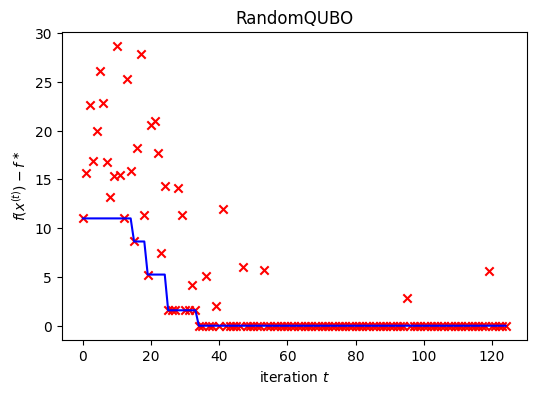

In [16]:
plot_x = X
plot_y = np.apply_along_axis(random_qubo.energy, 1, X)

plot_min_y = np.array([np.min(plot_y[:i]) for i in range(1, len(y) + 1)])

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

ax.plot(np.arange(len(plot_min_y)), plot_min_y - GS_energy, color="blue")
ax.scatter(np.arange(len(plot_y)), plot_y - GS_energy, color="red", marker="x")

ax.set_title("RandomQUBO")
ax.set_xlabel("iteration $t$")
ax.set_ylabel(r"$f(x^{(t)}) - f^\ast$")

plt.show()

今回は $d=16$ という小規模な設定なので、比較的簡単に最適解を発見することができています。最終的には $t=30$ 程度で最適解に到達しており、BOCSが上手く機能していることがわかります。

### RandomHUBO

3対相互作用を持つ高次元2値最適化も行ってみましょう。目的関数として

$$
  f(x) = \sum_{i,j,k} Q_{ijk} x_i x_j x_k
$$

を仮定してみます。

In [17]:
class RandomHUBO:
    def __init__(
        self, num_vars, noise_variance: float = 0.0, seed: Optional[int] = None
    ):
        self.noise_variance = noise_variance
        self.rng = np.random.default_rng(seed)
        self.Q = self.rng.normal(0, 1, size=(num_vars, num_vars, num_vars))

    def energy(self, x):
        return np.einsum("ijk,i,j,k", self.Q, x, x, x)

    def __call__(self, x):
        return self.energy(x) + self.rng.normal(0, np.sqrt(self.noise_variance))

In [18]:
seed = 0
rng = np.random.default_rng(seed)

num_vars = 16
num_init_samples = 5
noise_variance = 0.0

random_hubo = RandomHUBO(num_vars, noise_variance, seed)
surrogate_model = BOCSSurrogateModel(
    num_vars, linear_regressor=HorseshoeGibbs(max_iter=10)
)
acquisition_function = BOCSAcquisitionFunction(
    lambda Q: oj.SASampler().sample_qubo(Q, num_reads=5, num_sweeps=2500)
)

X = rng.choice([0, 1], size=(num_init_samples, num_vars))
y = np.array([random_hubo(x) for x in X])

# bayesian optimization loop
y_best = np.inf
for i in tqdm(range(150)):
    surrogate_model.update(X, y)
    acquisition_function.build(surrogate_model)
    x_next = acquisition_function.optimize()
    y_next = random_hubo(x_next)

    X = np.vstack([X, x_next])
    y = np.hstack([y, y_next])

    y_best = min(y_best, y_next)

    if i % 10 == 0:
        tqdm.write(
            f"iteration {i:4}: y_best = {y_best:6.3}: x_next = {x_next}"
        )

  0%|          | 0/150 [00:00<?, ?it/s]

iteration    0: y_best =  -13.6: x_next = [1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0]
iteration   10: y_best = -1.06e+02: x_next = [1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0]
iteration   20: y_best = -1.33e+02: x_next = [0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1]
iteration   30: y_best = -1.33e+02: x_next = [0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0]
iteration   40: y_best = -1.33e+02: x_next = [1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0]
iteration   50: y_best = -1.33e+02: x_next = [0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1]
iteration   60: y_best = -1.46e+02: x_next = [1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1]
iteration   70: y_best = -1.46e+02: x_next = [0 1 1 0 1 0 0 1 1 1 1 1 0 0 1 0]
iteration   80: y_best = -1.46e+02: x_next = [0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0]
iteration   90: y_best = -1.46e+02: x_next = [1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1]
iteration  100: y_best = -1.46e+02: x_next = [0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1]
iteration  110: y_best = -1.46e+02: x_next = [1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1]
iteration  120: y_best = -1.46e+02: x_next = [1 1 1 1 0

比較対象としてランダムに探索する方法でも実験してみます。

In [19]:
rng = np.random.default_rng(seed)

X_rand = rng.choice([0, 1], size=(150 + num_init_samples, num_vars))

得られた結果をプロットしてみましょう。

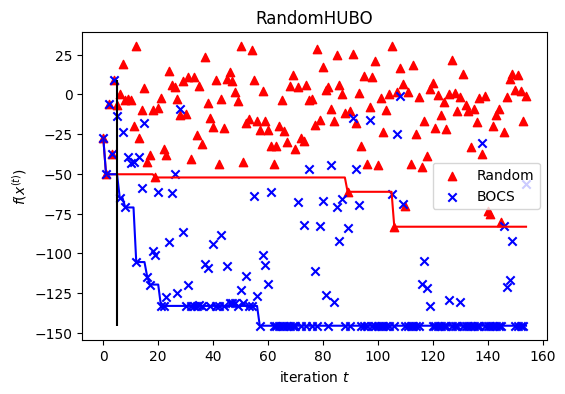

In [20]:
plot_x = X
plot_y = np.apply_along_axis(random_hubo.energy, 1, X)
plot_min_y = np.array([np.min(plot_y[:i]) for i in range(1, len(plot_y) + 1)])

plot_X_rand = X_rand
plot_y_rand = np.apply_along_axis(random_hubo.energy, 1, X_rand)
plot_min_y_rand = np.array(
    [np.min(plot_y_rand[:i]) for i in range(1, len(plot_y_rand) + 1)]
)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

ax.plot(np.arange(len(plot_min_y_rand)), plot_min_y_rand, color="red")
ax.scatter(
    np.arange(len(plot_y_rand)), plot_y_rand, color="red", marker="^", label="Random"
)

ax.plot(np.arange(len(plot_min_y)), plot_min_y, color="blue")
ax.scatter(np.arange(len(plot_y)), plot_y, color="blue", marker="x", label="BOCS")

ax.vlines(num_init_samples, min(plot_y), max(plot_y), color="black")

ax.set_title("RandomHUBO")
ax.set_xlabel(r"iteration $t$")
ax.set_ylabel(r"$f(x^{(t)})$")
ax.legend()
plt.show()

BOCSでは目的関数値の低い領域を中心にサンプルを集められていることがわかります。

### RandomMLP

更にもう1つ簡単な例として、多層パーセプトロンの最適化を行ってみます。ここでは後の拡張性も考えて、多層パーセプトロンはPyTorchで実装します。

In [21]:
import torch
import torch.nn as nn


class RandomMLP(nn.Module):
    def __init__(self, dim_in, dim_hidden):
        super().__init__()
        self.fc1 = nn.Linear(dim_in, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.fc3 = nn.Linear(dim_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)

        return x


class RandomMLPWrapper:
    def __init__(
        self,
        random_mlp_model: RandomMLP,
        noise_variance: float = 0.0,
        seed: Optional[int] = None,
    ):
        self.noise_variance = noise_variance
        self.rng = np.random.default_rng(seed)
        self.model = random_mlp_model

    def energy(self, x):
        x = torch.from_numpy(x).float()
        y = self.model(x)
        y = y.detach().numpy().item()
        return y

    def __call__(self, x: np.ndarray):
        return self.energy(x) + self.rng.normal(0, np.sqrt(self.noise_variance))

In [22]:
seed = 0
rng = np.random.default_rng(seed)

num_vars = 32
dim_hidden = 64
num_init_samples = 25
noise_variance = 0.0

random_mlp_model = RandomMLP(num_vars, dim_hidden)
random_mlp = RandomMLPWrapper(random_mlp_model, noise_variance, seed)
surrogate_model = BOCSSurrogateModel(
    num_vars, linear_regressor=HorseshoeGibbs(max_iter=50)
)
acquisition_function = BOCSAcquisitionFunction(
    lambda Q: oj.SASampler().sample_qubo(Q, num_reads=5, num_sweeps=2500)
)

X = rng.choice([0, 1], size=(num_init_samples, num_vars))
y = np.array([random_mlp(x) for x in X])

# bayesian optimization loop
y_best = np.inf
for i in tqdm(range(200)):
    surrogate_model.update(X, y)
    acquisition_function.build(surrogate_model)
    x_next = acquisition_function.optimize()
    y_next = random_mlp(x_next)

    X = np.vstack([X, x_next])
    y = np.hstack([y, y_next])

    y_best = min(y_best, y_next)

    if i % 10 == 0:
        tqdm.write(
            "iter: {:3d}, y_next: {:10.3e}, y_best: {:10.3e}".format(i, y_next, y_best)
        )

  0%|          | 0/200 [00:00<?, ?it/s]

iter:   0, y_next: -7.936e-02, y_best: -7.936e-02
iter:  10, y_next: -3.761e-02, y_best: -1.563e-01
iter:  20, y_next: -1.354e-01, y_best: -1.563e-01
iter:  30, y_next: -1.663e-01, y_best: -1.663e-01
iter:  40, y_next: -7.705e-02, y_best: -1.663e-01
iter:  50, y_next: -9.314e-02, y_best: -1.663e-01
iter:  60, y_next: -1.062e-01, y_best: -1.663e-01
iter:  70, y_next: -1.096e-01, y_best: -1.663e-01
iter:  80, y_next: -4.958e-02, y_best: -1.663e-01
iter:  90, y_next: -1.010e-01, y_best: -1.663e-01
iter: 100, y_next: -1.407e-01, y_best: -1.663e-01
iter: 110, y_next: -1.387e-01, y_best: -1.663e-01
iter: 120, y_next: -1.191e-01, y_best: -1.663e-01
iter: 130, y_next: -8.210e-02, y_best: -1.949e-01
iter: 140, y_next: -6.145e-02, y_best: -1.949e-01
iter: 150, y_next: -9.874e-02, y_best: -1.949e-01
iter: 160, y_next: -8.823e-02, y_best: -1.949e-01
iter: 170, y_next: -1.241e-01, y_best: -1.949e-01
iter: 180, y_next: -9.590e-02, y_best: -1.949e-01
iter: 190, y_next: -9.159e-02, y_best: -1.949e-01


ランダムに探索する方法も実験します。

In [23]:
rng = np.random.default_rng(seed)

X_rand = rng.choice([0, 1], size=(200 + num_init_samples, num_vars))

得られた結果をプロットします。

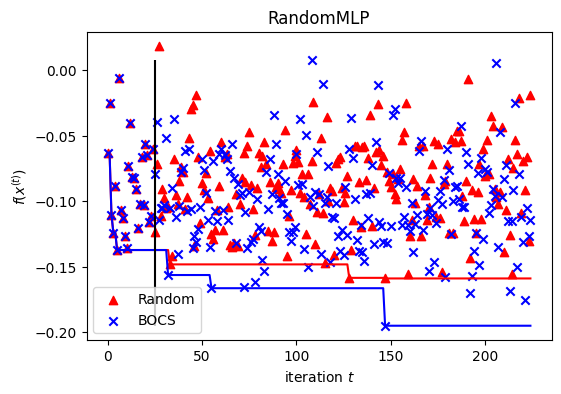

In [24]:
plot_x = X
plot_y = np.apply_along_axis(random_mlp.energy, 1, X)
plot_min_y = np.array([np.min(plot_y[:i]) for i in range(1, len(plot_y) + 1)])

plot_X_rand = X_rand
plot_y_rand = np.apply_along_axis(random_mlp.energy, 1, X_rand)
plot_min_y_rand = np.array(
    [np.min(plot_y_rand[:i]) for i in range(1, len(plot_y_rand) + 1)]
)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

ax.plot(np.arange(len(plot_min_y_rand)), plot_min_y_rand, color="red")
ax.scatter(
    np.arange(len(plot_y_rand)), plot_y_rand, color="red", marker="^", label="Random"
)

ax.plot(np.arange(len(plot_min_y)), plot_min_y, color="blue")
ax.scatter(np.arange(len(plot_y)), plot_y, color="blue", marker="x", label="BOCS")

ax.vlines(num_init_samples, min(plot_y), max(plot_y), color="black")

ax.set_title("RandomMLP")
ax.set_xlabel(r"iteration $t$")
ax.set_ylabel(r"$f(x^{(t)})$")
ax.legend()
plt.show()

Randomと比べれば比較的目的関数値の低い領域を探索できてはいますが、先程までの問題のように非常に性能がよいというわけではないようです。BOCSが使っている代理モデルは2次の項までしかモデル化できないため、目的関数が複雑な構造をしている場合、著しく性能が悪いこともあります。

## 補足: 縮小係数を考慮した事前分布について

この節では、本記事の途中で出てきた馬蹄分布をもう少し詳しく説明します。

### スパース性の仮定

線形回帰において、入力 $x^{(t)} \in \mathbb R^p$ が高次元な場合、つまり説明変数が多い場合は、特徴量 $x_i^{(t)}$ のうちのほとんどは出力 $y^{(t)}$ に寄与せず、ごく一部の成分が出力値に大きく影響する傾向にあることが知られています。よって、**スパース性** を仮定する、すなわち係数 $\bm \beta \in \mathbb R^p$ のうち **ごく一部の成分が大きく、それ以外は非常に小さい** ような推定をすると、データの個数 $N$ が少ない場合にもある程度うまく $\bm \beta$ を推定できると考えられます。このような知識を上手く取り込むことができる $\bm \beta$ の事前分布として、以下のような形の分布の定式化がよく行われます。

$$
\begin{aligned}
    \bm \beta \mid \sigma, \tau \bm \lambda \sim \mathcal N_p(\bm 0, \sigma^2 \tau^2 \operatorname{diag}(\bm \lambda^2)).
\end{aligned}
$$

ただし $\bm \lambda \in \mathbb R_+^p, \tau \in \mathbb R_+$ です。ここで、$\sigma, \tau, \bm \lambda$ が所与のもとで、ベイズの定理を用いて $\theta$ の事後分布を計算すると

$$
\begin{aligned}
    p(\bm \beta \mid \bm X, \bm y, \sigma, \tau, \bm \lambda)
    &\propto p(\bm y \mid \bm X, \bm \beta, \sigma, \tau, \bm \lambda) p(\bm \beta \mid \sigma, \tau, \bm \lambda) \\
    &= \prod_{t=1}^N p(y^{(t)} \mid \bm x^{(t)}, \bm \beta, \sigma, \tau, \bm \lambda) \times p(\bm \beta \mid \sigma, \tau, \bm \lambda) \\
    &\propto \exp \left( -\frac{1}{2\sigma^2} \sum_{t=1}^N  (y^{(t)} - \bm x^{(t) \top} \bm \beta)^2 \right) \times\exp \left( - \sum_{i=1}^p \frac{1}{2\sigma^2\tau^2\lambda_i^2} \beta_i^2 \right) \\
    &= \exp\left(
        -\frac{1}{2\sigma^2} \left(
            \left\| \bm y - \bm X \bm \beta \right\|_2^2 + \bm \beta^\top \mathop{\rm diag}\left\{ \frac{1}{\tau^2 \lambda_i^2} \right\} \bm \beta
        \right)
    \right) \\
    &= \exp\left(
        -\frac{1}{2} \left(
            \bm \beta^\top \frac{X^\top X}{\sigma^2} \bm \beta + \bm \beta^\top \mathop{\rm diag}\left\{ \frac{1}{\sigma^2\tau^2\lambda_i^2} \right\} \bm \beta - 2 \bm \beta^\top \frac{1}{\sigma^2} X^\top y + \mathrm{const.}
        \right)
    \right) \\
    &\propto \exp\left(
        -\frac{1}{2} \left(
            (\bm \beta - \bm \mu_N)^\top \bm \Sigma_N (\bm \beta - \bm \mu_n)
        \right)
    \right)
\end{aligned}
$$

となり、事後分布は多変量正規分布となることがわかります。

$$
\begin{aligned}
    \bm \beta \mid \cdot \sim \mathcal N_p(\bm \mu_N, \bm \Sigma_N)
\end{aligned}
$$

ただし $\bm X = [x_i^{(t)}]_{t,i} \in \mathbb R^{N \times p}$ は観測行列 (入力を並べた行列)、$\bm y = [y^{(t)}]_i \in \mathbb R^{N}$ は応答ベクトル (出力を並べたベクトル) であり、

$$
\begin{aligned}
    \bm \mu_N
    &= \sigma^2 \bm A^{-1}, \\
    \bm \Sigma_N
    &= \bm A^{-1} \bm X^\top \bm y, \\
    \bm A &= \bm X^\top \bm X + \mathop{\rm diag}\left\{ \frac{1}{\tau^2\lambda_i^2} \right\}
\end{aligned}
$$

です。

### 縮小係数

ここまで $y^{(i)} = \bm x^{(i) ~ \top} \bm \beta + \varepsilon$、つまり

$$
\begin{aligned}
  y^{(1)} &= \sum_i x^{(1)}_i \beta_i + \varepsilon \\
  y^{(2)} &= \sum_i x^{(2)}_i \beta_i + \varepsilon \\
  & \vdots \\
  y^{(N)} &= \sum_i x^{(N)}_i \beta_i + \varepsilon \\
\end{aligned}
$$

を考えてきましたが、ここから更に条件を追加して $N=p$ とし、$t$ 番目の観測で入力ベクトルの $t$ 番目の要素 $x_t^{(t)}$ のみが $1$、それ以外がすべて $0$ であるような入力 $\bm X=\bm I_p$ を与えたとして、

$$
\begin{aligned}
    y^{(i)} = \beta_i + \varepsilon \quad (t=1,\dots,p)
\end{aligned}
$$

という状況を考えます。事後平均 $\bm \mu_N$ は

$$
\begin{aligned}
\bm \mu_N
&= \left( \bm X^\top \bm X + \mathop{\rm diag}\left\{ \frac{1}{\tau^2 \lambda_i^2} \right\} \right)^{-1} \bm X^\top \bm y \\
&= \left( \bm I_p + \mathop{\rm diag}\left\{ \frac{1}{\tau^2 \lambda_i^2} \right\} \right)^{-1} \bm y
\end{aligned}
$$

となり、その第 $i$ 成分 $\mu_{N,i}$ は

$$
\begin{aligned}
\mu_{N,i} &= \dfrac{1}{1 + \dfrac{1}{\tau^2 \lambda_i^2}} y^{(i)} = \left( 1 - \dfrac{1}{1 + \tau^2 \lambda_i^2} \right) y^{(i)}
\end{aligned}
$$

となります。ここで

$$
\begin{aligned}
    \kappa_i = \frac{1}{1 + \tau^2 \lambda_i^2}
\end{aligned}
$$

とすれば

$$
\begin{aligned}
    \mu_{N,i} = (1 - \kappa_i) y_i
\end{aligned}
$$

となります。ここで新たに登場した $\kappa_i = \dfrac{1}{1 + \tau^2 \lambda_i^2}$ を縮小係数 (shrinkage coefficient) といいます。今 $0 \lt \tau^2 \lambda_i^2$ なので、縮小係数の取りうる範囲は $0 \lt \kappa_i \lt 1$ となります。当然ながら $0 \lt 1-\kappa_i \lt 1$ です。

上の式からわかるように、回帰係数 $\bm \beta$ の事後平均 $\bm \mu_N$ の第 $i$ 成分 $\mu_{N, i}$ は、$\bm y$ の第 $i$ 成分 $y_i$ を $1 - \kappa_i$ 倍に縮小した格好となっています。すなわち **縮小係数 $\kappa_i$ は観測された値 $y_i$ をどれほど $0$ に圧縮するかに寄与します**。$\kappa_i \approx 0$ の場合には $y_i$ がほとんどそのまま $\mu_{N, i}$ となる一方、$\kappa_i \approx 1$ の場合には $\mu_{N, i} \approx 0$ に圧縮します。そして $\kappa_i$ が $1$ に近いか $0$ に近いかは $\tau^2 \lambda_i^2$ の値によります。

以上をまとめると、

- $\tau^2 \lambda_i^2$ が $0$ に近いほど $\kappa_i$ は $1$ に近づき、$\mu_{N, i}$ は $0$ に圧縮される
- $\tau^2 \lambda_i^2$ が $1$ に近いほど $\kappa_i$ は $0$ に近づき、$\mu_{N, i}$ は圧縮されない

という特徴があるといえます。更に $\lambda_i^2$ は各 $\kappa_i$ の値に影響し、$\tau^2$ はすべての $\kappa_1, \kappa_2, \dots, \kappa_p$ に影響します。よって

- $\lambda_i$ は各係数の推定値 $\mu_{N, i}$ が $0$ に圧縮されるかに寄与する
- $\tau$ は係数の推定値全体 $\bm \mu_N$ が $0$ に圧縮されるかに寄与する

といえます。そこで $\lambda_i$ を **局所縮小パラメータ** (local shrinkage parameter)、$\tau$ を **大域縮小パラメータ** (global shrinkage parameter) といいます。

### 馬蹄分布

以上の議論によれば、縮小係数 $\kappa_i$ が推定値 $\mu_{N, i}$ に強く影響するので、縮小係数 $\kappa_i$ がどのような分布に従うのかが気になります。縮小係数は $\lambda_i$ と $\tau$ に影響を受けます。ここで簡単のために $\tau=1$ と固定する場合、$p(\kappa_i)$ は $\lambda_i$ の分布 $p(\lambda_i)$ を変数変換することにより得られます。

様々な $p(\lambda_i)$ に対応する $p(\kappa_i)$ の分布の具体的な形状は文献 [Carvalho+ (2009)] にまとめられていますが、特に $\lambda_i \sim \mathrm{HalfCauchy}(0,1)$ を設定した場合、$\kappa_i$ は次のようなベータ分布 $\mathop{\rm Beta}(0.5, 0.5)$ に従います。

$$
\begin{aligned}
  p(\kappa_i) = \frac{1}{\pi}(1-\kappa_i)^{-1/2}\kappa_i^{-1/2}
\end{aligned}
$$

さて、ベータ分布 $\mathop{\rm Beta}(0.5, 0.5)$ の確率密度関数をプロットすると、以下のように馬の蹄 (ひずめ) のような形状が現れます。

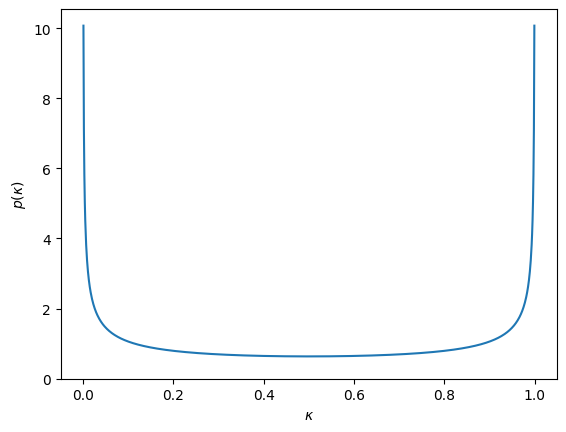

In [25]:
from scipy.special import beta


def _beta_pdf(x, a, b):
    p = 1.0 / beta(a, b) * (1.0 - x) ** (-a) * x ** (-b)
    return p


x_plot = np.linspace(1e-3, 1.0 - 1e-3, 1000)
y_plot = _beta_pdf(x_plot, 0.5, 0.5)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_plot, y_plot)
ax.set_xlabel(r"$\kappa$")
ax.set_ylabel(r"$p(\kappa)$")
ax.set_ylim(0.0)
plt.show()

このことから、特に $\lambda_i \sim \mathrm{HalfCauchy}(0, 1)$ を仮定する場合、この $\theta$ の事前分布は馬蹄分布 (horseshoe distribution) と呼ばれます。

確率密度関数の形状を見ると明らかなように、馬蹄分布は $\kappa_i \approx 0$ または $\kappa_i \approx 1$ の値を取りやすいという性質を持っています。このような性質から、馬蹄分布を用いることで推定値のうち一部は $0$ に、残りは $0$ に圧縮された推定値を補うような大きな値になることが期待されます。

なお馬蹄分布の由来は縮小係数 $\kappa_i$ がベータ分布 $\mathop{\rm Beta}(0.5,0.5)$ に従うことにありますが、ベータ分布そのものを馬蹄分布と呼ぶのではなく、あくまで $\theta$ の事前分布を馬蹄分布と呼ぶということに注意してください。

## あとがき

本記事ではBOCSの最も基本的な実装を行いました。自分の手で実装することでThompson抽出によるベイズ最適化のフレームワークについて理解することができ、さらに組合せ最適化問題への適用に関する難しさも知ることができました。

またBOCSにおける課題として

- 制約条件付きの問題はどうするのか
- データの数 $N$ や入力次元 $d$ が大きくなると計算コストが大きくなる問題はどうするのか

などの点が気になりました。今後はこのような課題がどのように扱われているのかを調べたり、解決策を探したりして、BOCSの改善策について考えていきたいと思います。

## 参考文献

- [Carvalho+ (2009)] C. M. Carvalho, N. G. Polson, and J. G. Scott, Handling Sparsity via the Horseshoe, in Proceedings of the Twelth International Conference on Artificial Intelligence and Statistics (PMLR, 2009), pp. 73–80.
- [Wand+ (2011)] M. P. Wand, J. T. Ormerod, S. A. Padoan, and R. Frühwirth, Mean Field Variational Bayes for Elaborate Distributions, Bayesian Analysis **6**, 847 (2011).
- [Bhattacharya+ (2016)] A. Bhattacharya, A. Chakraborty, and B. K. Mallick, Fast Sampling with Gaussian Scale Mixture Priors in High-Dimensional Regression, Biometrika **103**, 985 (2016).
- [Makalic & Schmidt (2016)] E. Makalic and D. F. Schmidt, A Simple Sampler for the Horseshoe Estimator, IEEE Signal Processing Letters **23**, 179 (2016).
- [Baptista & Poloczek (2018)] R. Baptista and M. Poloczek, Bayesian Optimization of Combinatorial Structures, in Proceedings of the 35th International Conference on Machine Learning, edited by J. Dy and A. Krause, Vol. 80 (PMLR, 2018), pp. 462–471.

## 本記事の担当者

森田圭祐